## feature matrix

### preprocess

In [ ]:
import pandas as pd

In [ ]:
df=pd.read_csv('ipc_description_2024ver_maingroup.csv', encoding='utf-8-sig')

In [ ]:
df

In [ ]:
def transform_code(code):
    # '/00' 제거
    if code.endswith('/00'):
        code = code[:-3]
    # 마지막 알파벳 위치 찾기
    last_alpha_index = max(code.rfind(c) for c in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    if last_alpha_index == -1:
        return code
    prefix = code[:last_alpha_index+1]
    number = code[last_alpha_index+1:]
    number = number.zfill(3)
    return prefix + number

df['maingroup'] = df['code'].apply(transform_code)

In [ ]:
df.to_csv('ipc_description_2024ver_maingroup_p.csv', encoding='utf-8-sig')

### AI filtering

In [ ]:
df=pd.read_csv('ipc_description_2024ver_maingroup_p.csv', encoding='utf-8-sig')

In [ ]:
df2=pd.read_csv('AI_patent_processed.csv', encoding='utf-8')

In [ ]:
ipc_list = df2['ipc'].dropna().str.split(',').explode().str.strip().unique().tolist()

In [ ]:
filtered_df = df[df['maingroup'].isin(ipc_list)]

In [ ]:
filtered_df.to_csv('AI_ipc_description_2024ver_maingroup_p.csv', encoding='utf-8-sig')

### embedding(BERT)

In [38]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

C:\Users\user\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [39]:
df = pd.read_csv('AI_ipc_description_2024ver_maingroup_p.csv', encoding='utf-8-sig')

In [40]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# 문서 임베딩 함수
def get_bert_embedding(text):
    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    
    with torch.no_grad():
        output = model(**encoded_input)
    
    # [CLS] 토큰의 마지막 은닉 상태 사용 (문서 임베딩으로)
    return output.last_hidden_state[:, 0, :].cpu().numpy()[0]

# 임베딩 생성 및 저장
embeddings = []
for desc in tqdm(df['description']):
    embeddings.append(get_bert_embedding(desc))

df['embedding'] = embeddings

100%|██████████████████████████████████████████████████████████████████████████████| 1599/1599 [00:46<00:00, 34.61it/s]


In [41]:
df.to_csv('AI_ipc_embedding_BERT.csv', encoding='utf-8-sig')

### embedding(doc2vec)

In [33]:
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

In [34]:
df = pd.read_csv('AI_ipc_description_2024ver_maingroup_p.csv', encoding='utf-8-sig')

In [35]:
tagged_data = [TaggedDocument(words=word_tokenize(str(desc).lower()), 
                             tags=[str(maingroup)]) 
              for maingroup, desc in zip(df['maingroup'], df['description'])]

# 데이터 분할
train_data, val_data = train_test_split(tagged_data, test_size=0.2, random_state=42)

def evaluate_model(model, val_data):
    """유사도 기반 모델 평가 함수"""
    similarities = []
    for doc in val_data:
        inferred_vector = model.infer_vector(doc.words)
        sims = cosine_similarity([inferred_vector], model.dv.vectors)
        similarities.append(np.max(sims))
    return np.mean(similarities)

# 하이퍼파라미터 그리드
param_grid = {
    'vector_size': [100, 150, 200],
    'window': [5, 7, 10],
    'min_count': [1, 2],
    'epochs': [30, 40],
    'dm': [0, 1]  # 0: DBOW, 1: DM
}

# 최적화 결과 저장
results = []

# 그리드 서치 실행
for vs in param_grid['vector_size']:
    for w in param_grid['window']:
        for mc in param_grid['min_count']:
            for e in param_grid['epochs']:
                for dm in param_grid['dm']:
                    model = Doc2Vec(
                        vector_size=vs,
                        window=w,
                        min_count=mc,
                        epochs=e,
                        dm=dm,
                        workers=4
                    )
                    model.build_vocab(train_data)
                    model.train(train_data, 
                              total_examples=model.corpus_count, 
                              epochs=model.epochs)
                    
                    score = evaluate_model(model, val_data)
                    results.append({
                        'vector_size': vs,
                        'window': w,
                        'min_count': mc,
                        'epochs': e,
                        'dm': dm,
                        'score': score
                    })

# 결과 분석
results_df = pd.DataFrame(results)
best_params = results_df.loc[results_df['score'].idxmax()]
print("최적 파라미터:\n", best_params)

최적 파라미터:
 vector_size    200.000000
window           7.000000
min_count        1.000000
epochs          30.000000
dm               0.000000
score            0.988441
Name: 56, dtype: float64


In [36]:
# 문서 전처리 및 태깅
tagged_data = [TaggedDocument(words=word_tokenize(desc.lower()), 
                             tags=[maingroup]) 
               for maingroup, desc in zip(df['maingroup'], df['description'])]

# Doc2Vec 모델 학습
model = Doc2Vec(vector_size=200,  # 벡터 차원
                window=7,         # 컨텍스트 윈도우 크기
                min_count=1,      # 최소 단어 빈도
                workers=4,        # 사용할 CPU 코어 수
                epochs=30,
               dm=0)        # 훈련 반복 횟수

model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# 모델 저장
model.save('ipc_doc2vec_model')

# 벡터 추출
document_vectors = {doc_tag: model.dv[doc_tag] for doc_tag in model.dv.index_to_key}

# 데이터프레임에 벡터 추가
df['embedding'] = df['maingroup'].map(document_vectors)

In [37]:
df.to_csv('AI_ipc_embedding_doc2vec.csv', encoding='utf-8-sig')

### IPC features

#### Growing rate in the network (GIN)

In [1]:
import pandas as pd
import numpy as np
df=pd.read_csv('AI_patent_train.csv', encoding='utf-8')

In [2]:
df

,number,year,title,abs,claims,ipc,country,assignee,backward
0,10524461,2020,Pest detector to identify a type of pest using...,"In some implementations, a detector may includ...",20,"A01M001, G06K009, G06F009, G01S013, G06F001, G...",None,None,"6445301, 7441368, 8400348, 9385953, 9792557, 1..."
1,10524737,2020,Condition detection in a virtual reality syste...,Techniques that facilitate condition detection...,17,"A61B005, G06F003, A61B005, A61B005, A61B005, G...",US,International Business Machines Corporation,"6201476, 6433690, 8206325, 9753285"
2,10524761,2020,Enhanced stethoscope devices and methods,An enhanced stethoscope device and method for ...,33,"A61B007, A61B005, A61B008, A61B005, G01S015, A...",US,California Institute of Technology,"4413629, 4768174, 4972841, 5394880, 5798489, 5..."
3,10525563,2020,Abnormality-detecting device and method for to...,An abnormality-detecting device for detecting ...,14,"B23Q017, G05B013, G05B023, B23Q017, G05B013, G...",JP,"MITSUBISHI HEAVY INDUSTRIES MACHINE TOOL CO., ...","5579232, 9349099, 10379517"
4,10525615,2020,Water regulated temperature controlled resin d...,Apparatus and method for drying thermoplastic ...,3,"B29B013, F26B021, F26B021, F26B023, F26B003, F...",US,"Novatec, Inc.","3233416, 4601114, 4670203, 7316079, 7568905, 1..."
...,...,...,...,...,...,...,...,...,...
27245,11856369,2023,Methods and systems implementing phonologicall...,A hearing aid system presents a hearing impair...,16,"H04R025, G10L017, G06N003, G10L021",None,None,10791404
27246,11856424,2023,Method for creating network simulation platfor...,A method for creating a network simulation pla...,20,"H04W016, H04W024, G06N003, G06N003, H04L041",CN,"Huawei Technologies Co., Ltd.","9439081, 10477426"
27247,11856499,2023,Emergency mode for mobile devices,Methods and apparatuses for emergency modes fo...,14,"H04W004, G10L015, H04W004, G10L017",US,"Micron Technology, Inc.",6263311
27248,11856524,2023,Systems and methods for deep reinforcement lea...,Wireless networks with plural nodes having a r...,33,"H04W052, H04W052",US,"INTELLIGENT AUTOMATION, LLC",None


In [3]:
def count_backward(x):
    if pd.isna(x) or x in ['None', 'nan']:
        return 0
    return len(str(x).split(', '))

# IPC 분리 및 backward 개수 확장
df_exploded = df.assign(ipc=df['ipc'].str.split(', ')).explode('ipc')
df_exploded['backward_count'] = df_exploded['backward'].apply(count_backward)

# IPC별 평균 backward 개수
result = df_exploded.groupby('ipc')['backward_count'].mean().reset_index()

# 연도별 IPC별 특허 수 피벗 테이블
ipc_year_counts = df_exploded.groupby(['year', 'ipc']).size().reset_index(name='patent_count')
ipc_year_pivot = ipc_year_counts.pivot(index='year', columns='ipc', values='patent_count').fillna(0)

# 피벗 테이블을 전치(transpose)하여 IPC를 index로 만듦
ipc_year_pivot_T = ipc_year_pivot.transpose().reset_index()

# result와 ipc 기준으로 병합
final = pd.merge(result, ipc_year_pivot_T, on='ipc', how='left')

In [4]:
final

,ipc,backward_count,2020,2021,2022,2023
0,A01B003,10.0,1.0,0.0,0.0,0.0
1,A01B043,7.0,0.0,1.0,0.0,1.0
2,A01B049,7.5,2.0,0.0,0.0,0.0
3,A01B059,7.0,0.0,1.0,0.0,1.0
4,A01B063,6.6,2.0,0.0,3.0,0.0
...,...,...,...,...,...,...
1436,H10K019,28.0,0.0,0.0,0.0,1.0
1437,H10K085,28.0,0.0,0.0,0.0,1.0
1438,H10N035,3.0,0.0,0.0,0.0,2.0
1439,H10N050,1.0,0.0,0.0,0.0,1.0


In [5]:
# Top20 assignee 선정
top20_assignees = df['assignee'].fillna('None').value_counts().iloc[:20].index.tolist()
df_top20 = df[df['assignee'].fillna('None').isin(top20_assignees)]

# IPC 분해 및 건수 집계
df_top20_exploded = df_top20.assign(ipc=df_top20['ipc'].str.split(', ')).explode('ipc')
ipc_top20_counts = df_top20_exploded['ipc'].value_counts()

# 전체 IPC별 특허 건수(final 활용)
final['total_count'] = final.drop(columns=['ipc', 'backward_count']).sum(axis=1)
ipc_counts_df = pd.DataFrame({'ipc': ipc_top20_counts.index, 'top20_count': ipc_top20_counts.values})
merged = pd.merge(final, ipc_counts_df, on='ipc', how='left').fillna(0)
merged['top20_proportion'] = merged['top20_count'] / merged['total_count']

# 결과
merged

,ipc,backward_count,2020,2021,2022,2023,total_count,top20_count,top20_proportion
0,A01B003,10.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,A01B043,7.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0
2,A01B049,7.5,2.0,0.0,0.0,0.0,2.0,0.0,0.0
3,A01B059,7.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0
4,A01B063,6.6,2.0,0.0,3.0,0.0,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1436,H10K019,28.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1437,H10K085,28.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1438,H10N035,3.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0
1439,H10N050,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [ ]:
merged.to_csv('year_maingroup_train.csv', encoding='utf-8-sig')

### 네트워크 구조적 특징 반영

#### centrality

In [6]:
import pandas as pd
import numpy as np

df = pd.read_csv('adj_train.csv', encoding='utf-8-sig', index_col=0)
adj_matrix = df.values  # numpy array로 변환
nodes = df.index.tolist()  # 노드명(IPC 코드) 리스트

In [7]:
import networkx as nx

G = nx.from_numpy_array(adj_matrix)
mapping = dict(zip(range(len(nodes)), nodes))
G = nx.relabel_nodes(G, mapping)

In [8]:
# Degree Centrality
degree_centrality = nx.degree_centrality(G)

# Closeness Centrality
closeness_centrality = nx.closeness_centrality(G)

# Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality_numpy(G)

#### node2vec

In [ ]:
! pip install node2vec

In [22]:
from node2vec import Node2Vec
df = pd.read_csv('adj_train.csv', encoding='utf-8-sig', index_col=0)

# 2. 인접 행렬을 networkx 그래프로 변환
adj_matrix = df.values
G = nx.from_numpy_array(adj_matrix)  # 무방향 그래프. 방향성이 있다면 nx.from_numpy_matrix(adj_matrix, create_using=nx.DiGraph)

# 노드 이름이 숫자로 매핑되므로, 필요하면 다음과 같이 노드 이름을 매핑
mapping = dict(zip(range(len(df.index)), df.index))
G = nx.relabel_nodes(G, mapping)

# 3. node2vec 임베딩 생성
node2vec = Node2Vec(G, dimensions=128, walk_length=80, num_walks=10, workers=1)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# 4. 각 노드별 임베딩 벡터 추출
embedding = model.wv  # Gensim KeyedVectors 객체
vector = embedding['A01B003']  # 예시: 특정 노드의 임베딩 벡터

Computing transition probabilities:   0%|          | 0/1441 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.75s/it]


In [23]:
embedding_dict = {node: embedding[node] for node in embedding.index_to_key}
emb_df = pd.DataFrame.from_dict(embedding_dict, orient='index')
emb_df.columns = [f'N{i+1}' for i in range(emb_df.shape[1])]
emb_df['ipc'] = emb_df.index
emb_df = emb_df.reset_index(drop=True)

In [24]:
emb_df

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,N120,N121,N122,N123,N124,N125,N126,N127,N128,ipc
0,-0.001215,-0.118765,0.013957,-0.002613,-0.120753,-0.128786,-0.031382,-0.044249,0.138633,0.147366,...,0.039469,0.122497,-0.170856,-0.150027,-0.075383,0.140263,-0.018931,-0.268399,0.195343,G06N003
1,0.068021,-0.210767,0.022056,0.034321,0.033955,-0.007671,-0.062497,0.080815,0.092783,0.101749,...,0.025599,0.023305,-0.264852,-0.058676,-0.080758,0.048473,-0.028618,-0.222606,-0.022150,G06N020
2,0.084265,-0.240866,0.121971,0.031186,-0.046758,0.004897,-0.014697,0.065569,0.069840,0.177406,...,0.011543,0.048904,-0.123380,-0.206911,-0.078461,0.031682,-0.067109,-0.197355,0.114109,G06K009
3,0.210807,-0.220556,-0.000243,-0.022876,0.052516,-0.006776,-0.102449,0.180430,0.182023,0.160905,...,-0.159872,-0.060572,-0.317767,-0.125376,-0.112915,0.071225,0.010517,-0.194917,0.034867,G06F016
4,0.165839,-0.269732,0.067724,0.124832,-0.050053,-0.086259,-0.088579,0.090171,0.107270,0.093658,...,0.077482,0.077776,-0.124468,-0.226035,-0.095066,0.076548,-0.052540,-0.223187,0.031645,G06T007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1436,0.109391,-0.065860,0.044081,0.028161,-0.027008,0.026874,-0.013846,0.028695,0.184408,0.208185,...,-0.018173,0.082514,-0.227154,-0.010967,-0.067001,0.041805,-0.050895,-0.138768,0.010221,B01D035
1437,0.043374,-0.063449,-0.054121,0.127220,-0.008934,-0.021913,-0.093485,0.171816,0.041861,0.123613,...,-0.023827,-0.007545,-0.111798,0.008480,0.177440,0.027330,-0.072655,-0.183086,0.085457,A61G005
1438,0.156446,0.027783,0.014366,0.141682,0.123766,0.022140,0.075116,0.104567,0.015459,0.206882,...,-0.058371,0.060487,-0.019542,-0.186982,0.024429,-0.101840,-0.090274,-0.115563,0.082810,B25J001
1439,0.002130,-0.154308,0.049252,0.110075,0.092547,-0.017954,-0.106957,-0.032246,0.150068,0.285763,...,0.122350,0.036663,-0.029875,-0.037264,-0.082085,-0.067738,-0.016600,-0.123862,0.034371,A23L003


In [29]:
merged

,ipc,backward_count,2020,2021,2022,2023,total_count,top20_count,top20_proportion
0,A01B003,10.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,A01B043,7.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0
2,A01B049,7.5,2.0,0.0,0.0,0.0,2.0,0.0,0.0
3,A01B059,7.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0
4,A01B063,6.6,2.0,0.0,3.0,0.0,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1436,H10K019,28.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1437,H10K085,28.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1438,H10N035,3.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0
1439,H10N050,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [30]:
# 구조적 특성 DataFrame
structural_df = pd.DataFrame({
    'ipc': nodes,
    'degree_centrality': [degree_centrality[n] for n in nodes],
    'closeness_centrality': [closeness_centrality[n] for n in nodes],
    'betweenness_centrality': [betweenness_centrality[n] for n in nodes],
    'eigenvector_centrality': [eigenvector_centrality[n] for n in nodes]
})

# 최종 feature matrix 결합
feature_matrix = merged.merge(structural_df, on='ipc', how='left').merge(emb_df, on='ipc', how='left')

In [32]:
feature_matrix.to_csv('0514_FeatureMatrix.csv', encoding='utf-8-sig', index=False)

### feature 결합

In [42]:
import ast
df=pd.read_csv('year_maingroup_train.csv', encoding='utf-8-sig')
df2=pd.read_csv('AI_ipc_embedding_BERT.csv', encoding='utf-8-sig')

In [43]:
df2

,Unnamed: 0,maingroup,description,embedding
0,0,A01B003,Ploughs with fixed plough-shares,[-1.07687223e+00 -2.37220284e-02 -4.51724716e-...
1,1,A01B039,Other machines specially adapted for working s...,[-3.35794270e-01 1.94509983e-01 -3.56953770e-...
2,2,A01B043,"Gatherers for removing stones, undesirable roo...",[-6.33953094e-01 -1.92982405e-01 -5.99012315e-...
3,3,A01B049,Combined machines (auxiliary devices attached ...,[-2.13012859e-01 -1.13296993e-01 4.99576703e-...
4,4,A01B059,Devices specially adapted for connection betwe...,[-4.83070672e-01 -3.12228054e-01 -3.93939316e-...
...,...,...,...,...
1594,1594,H10K085,Organic materials used in the body or electrod...,[-6.33694530e-02 2.39817619e-01 -7.63432235e-...
1595,1595,H10N035,Magnetostrictive devices (integrated devices o...,[-1.37267277e-01 -5.71052693e-02 -5.15569560e-...
1596,1596,H10N050,Galvanomagnetic devices (Hall-effect devices H...,[-3.92014802e-01 -1.96385294e-01 -3.59387785e-...
1597,1597,H10N060,Superconducting devices (integrated devices or...,[-1.70364037e-01 -1.51206970e-01 -5.00204675e-...


In [44]:
df_merged = pd.merge(df, df2[['maingroup', 'embedding']], on='maingroup', how='left')

In [45]:
df_merged

,maingroup,2020,2021,2022,2023,FAP,GIN,FIN,embedding
0,A01B003,1,0,0,0,0,-0.3,1,[-1.07687223e+00 -2.37220284e-02 -4.51724716e-...
1,A01B043,0,1,0,1,1,0.2,2,[-6.33953094e-01 -1.92982405e-01 -5.99012315e-...
2,A01B049,2,0,0,0,0,-0.6,2,[-2.13012859e-01 -1.13296993e-01 4.99576703e-...
3,A01B059,0,1,0,1,1,0.2,2,[-4.83070672e-01 -3.12228054e-01 -3.93939316e-...
4,A01B063,2,0,3,0,0,-0.3,5,[-5.37546992e-01 9.46517438e-02 -3.33496332e-...
...,...,...,...,...,...,...,...,...,...
1436,H10K019,0,0,0,1,1,0.3,1,[-6.19125247e-01 -1.57228321e-01 -2.12497085e-...
1437,H10K085,0,0,0,1,1,0.3,1,[-6.33694530e-02 2.39817619e-01 -7.63432235e-...
1438,H10N035,0,0,0,2,2,0.6,2,[-1.37267277e-01 -5.71052693e-02 -5.15569560e-...
1439,H10N050,0,0,0,1,1,0.3,1,[-3.92014802e-01 -1.96385294e-01 -3.59387785e-...


In [46]:
df_merged['embedding_clean'] = df_merged['embedding'].str.replace('[\[\]]', '', regex=True)

# 2. 공백 기준 분리하여 DataFrame으로 변환
embedding_df = df_merged['embedding_clean'].str.split(expand=True)

# 3. 컬럼 이름 지정 (embedding_0, embedding_1, ...)
embedding_df.columns = [f'E{i}' for i in range(embedding_df.shape[1])]

# 4. float형으로 변환
embedding_df = embedding_df.astype(float)

# 5. 기존 df2와 합치기 (원하면 drop=['embedding', 'embedding_clean']로 기존 열 삭제)
df_merged = pd.concat([df_merged, embedding_df], axis=1)

In [47]:
df_merged.to_csv('feature_matrix_train_BERT2.csv', encoding='utf-8-sig')

## GCN Link Prediction

In [1]:
import pandas as pd

In [4]:
df=pd.read_csv('0514_FeatureMatrix_doc2vec.csv', encoding='utf-8-sig')
df2=pd.read_csv('adj_train.csv', encoding='utf-8-sig')
df3=pd.read_csv('0514_FeatureMatrix_BERT.csv', encoding='utf-8-sig')

In [5]:
df

,ipc,2020,2021,2022,2023,backward_count,FAP,GIN,FIN,top20_count,...,E190,E191,E192,E193,E194,E195,E196,E197,E198,E199
0,A01B003,1,0,0,0,10.0,0,-0.3,1,0,...,0.006664,0.114189,-0.009951,0.042913,0.014057,0.086022,0.037459,-0.150228,0.024170,0.078573
1,A01B043,0,1,0,1,7.0,1,0.2,2,0,...,0.004438,0.169063,-0.013083,0.060707,0.021045,0.124767,0.050557,-0.238611,0.033637,0.122846
2,A01B049,2,0,0,0,7.5,0,-0.6,2,0,...,-0.068274,0.180527,-0.094359,0.038766,0.059033,0.160800,0.120417,-0.274191,0.039353,0.101340
3,A01B059,0,1,0,1,7.0,1,0.2,2,0,...,0.004783,0.205719,-0.007079,0.078138,0.038711,0.151842,0.058105,-0.258835,0.034393,0.147257
4,A01B063,2,0,3,0,6.6,0,-0.3,5,0,...,-0.063381,0.189730,-0.097839,0.037632,0.034445,0.151418,0.106981,-0.286486,0.016164,0.108864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1436,H10K019,0,0,0,1,28.0,1,0.3,1,0,...,0.000099,0.170649,-0.023311,0.059432,0.020199,0.122171,0.048710,-0.223247,0.040263,0.123713
1437,H10K085,0,0,0,1,28.0,1,0.3,1,0,...,0.012568,0.148509,-0.020793,0.053643,0.017934,0.102705,0.062038,-0.195666,0.029765,0.106640
1438,H10N035,0,0,0,2,3.0,2,0.6,2,0,...,0.008187,0.134369,-0.016081,0.047963,0.016392,0.094505,0.037690,-0.178287,0.026111,0.092359
1439,H10N050,0,0,0,1,1.0,1,0.3,1,0,...,0.014416,0.159964,-0.019141,0.059834,0.016300,0.114785,0.046034,-0.208370,0.028253,0.118255


### positive link and negative link

In [6]:
# adj_train.csv의 인접행렬에서 연결된 노드 쌍 추출
positive_links = []
for i in range(len(df2)):
    maingroup_i = df2.iloc[i, 0]  # 첫 번째 열이 maingroup
    for j in range(1, len(df2.columns)):
        maingroup_j = df2.columns[j]
        weight = df2.iloc[i, j]
        if weight > 0:  # 공동출현 횟수가 있는 경우 (값이 0보다 큰 경우)
            positive_links.append((maingroup_i, maingroup_j, 1))  # 1은 긍정적 링크 라벨

In [7]:
# 연결되지 않은 노드 쌍에서 무작위 샘플링
import random
import numpy as np

negative_links = []
ipc_codes = df['ipc'].unique()
n_positive = len(positive_links)

# 긍정적 링크 수와 동일한 수의 부정적 링크 생성
while len(negative_links) < n_positive:
    i, j = random.sample(list(ipc_codes), 2)
    # 이미 연결된 쌍이 아닌지 확인
    if df2.loc[df2.iloc[:, 0] == i, j].values[0] == 0:
        negative_links.append((i, j, 0))  # 0은 부정적 링크 라벨


### 노드 인덱스 매핑

In [8]:
df

,ipc,2020,2021,2022,2023,backward_count,FAP,GIN,FIN,top20_count,...,E190,E191,E192,E193,E194,E195,E196,E197,E198,E199
0,A01B003,1,0,0,0,10.0,0,-0.3,1,0,...,0.006664,0.114189,-0.009951,0.042913,0.014057,0.086022,0.037459,-0.150228,0.024170,0.078573
1,A01B043,0,1,0,1,7.0,1,0.2,2,0,...,0.004438,0.169063,-0.013083,0.060707,0.021045,0.124767,0.050557,-0.238611,0.033637,0.122846
2,A01B049,2,0,0,0,7.5,0,-0.6,2,0,...,-0.068274,0.180527,-0.094359,0.038766,0.059033,0.160800,0.120417,-0.274191,0.039353,0.101340
3,A01B059,0,1,0,1,7.0,1,0.2,2,0,...,0.004783,0.205719,-0.007079,0.078138,0.038711,0.151842,0.058105,-0.258835,0.034393,0.147257
4,A01B063,2,0,3,0,6.6,0,-0.3,5,0,...,-0.063381,0.189730,-0.097839,0.037632,0.034445,0.151418,0.106981,-0.286486,0.016164,0.108864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1436,H10K019,0,0,0,1,28.0,1,0.3,1,0,...,0.000099,0.170649,-0.023311,0.059432,0.020199,0.122171,0.048710,-0.223247,0.040263,0.123713
1437,H10K085,0,0,0,1,28.0,1,0.3,1,0,...,0.012568,0.148509,-0.020793,0.053643,0.017934,0.102705,0.062038,-0.195666,0.029765,0.106640
1438,H10N035,0,0,0,2,3.0,2,0.6,2,0,...,0.008187,0.134369,-0.016081,0.047963,0.016392,0.094505,0.037690,-0.178287,0.026111,0.092359
1439,H10N050,0,0,0,1,1.0,1,0.3,1,0,...,0.014416,0.159964,-0.019141,0.059834,0.016300,0.114785,0.046034,-0.208370,0.028253,0.118255


In [9]:
# IPC 코드와 인덱스 매핑 (문자열 -> 정수)
ipc_to_idx = {ipc: idx for idx, ipc in enumerate(df['ipc'])}
idx_to_ipc = {idx: ipc for ipc, idx in ipc_to_idx.items()}

In [12]:
node_only=df.iloc[:, 5:11].values
node_network=df.iloc[:, 11:143].values
centrality=df.iloc[:, 11:15].values
n2v=df.iloc[:, 15:143].values
d2v=df.iloc[:, 143:].values
bert=df3.iloc[:, 143:].values
all_d2v=df.iloc[:, 5:].values
all_bert=df3.iloc[:, 5:].values
n2v_d2v=df.iloc[:, 15:].values
n2v_bert=df3.iloc[:, 15:].values
network_d2v=df.iloc[:, 11:].values
network_bert=df3.iloc[:, 11:].values

In [14]:
# 인접 행렬을 희소 행렬로 변환 (메모리 효율성)
from scipy.sparse import csr_matrix
adj_indices = []

for i, row_ipc in enumerate(df2.iloc[:, 0]):
    for j, col_ipc in enumerate(df2.columns[1:], 1):
        if df2.iloc[i, j] > 0:
            adj_indices.append((ipc_to_idx[row_ipc], ipc_to_idx[col_ipc], df2.iloc[i, j]))

rows, cols, values = zip(*adj_indices)
adj_matrix = csr_matrix((values, (rows, cols)), shape=(len(ipc_to_idx), len(ipc_to_idx)))

### GCN 구현

In [16]:
# pip install torch_geometric

In [22]:
# # PyTorch 버전과 CUDA 버전 확인
# import torch
# TORCH_version = torch.__version__.split('+')[0]
# CUDA_version = 'cpu' if not torch.cuda.is_available() else 'cu' + torch.version.cuda.replace('.', '')

# # pip 대신 python3 -m pip 사용
# !python3 -m pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-{TORCH_version}+{CUDA_version}.html
# !python3 -m pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-{TORCH_version}+{CUDA_version}.html
# !python3 -m pip install torch-geometric


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCNLinkPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        
        # 링크 예측을 위한 MLP
        self.predictor = nn.Sequential(
            nn.Linear(out_channels * 2, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1)
        )
    
    def encode(self, x, edge_index, edge_weight=None):
        # 노드 임베딩 생성
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x
    
    def decode(self, z, edge_index):
        # 소스 노드와 타겟 노드의 임베딩
        src, dst = edge_index
        src_emb = z[src]
        dst_emb = z[dst]
        
        # 두 노드 임베딩 결합 (연결)
        x = torch.cat([src_emb, dst_emb], dim=1)
        
        # 링크 예측
        return self.predictor(x)
    
    def forward(self, x, edge_index, edge_weight, pred_edge_index):
        # 노드 임베딩 생성
        z = self.encode(x, edge_index, edge_weight)
        
        # 링크 예측
        return self.decode(z, pred_edge_index)


### gcn 학습

In [212]:
#feature_matrix=node_only
#feature_matrix=node_network
#feature_matrix=n2v
#feature_matrix=d2v
#feature_matrix=bert
#feature_matrix=all_d2v
#feature_matrix=all_bert
#feature_matrix=n2v_d2v
#feature_matrix=n2v_bert
#feature_matrix=network_d2v
feature_matrix=network_bert

In [28]:
feature_matrices = {
    'node_only': node_only,
    'node_network': node_network,
    'centrality': centrality,
    'n2v': n2v,
    'd2v': d2v,
    'bert': bert,
    'all_d2v': all_d2v,
    'all_bert': all_bert,
    'n2v_d2v': n2v_d2v,
    'n2v_bert': n2v_bert,
    'network_d2v': network_d2v,
    'network_bert': network_bert
}

#### 데이터 분할

In [24]:
# 링크를 학습/검증 세트로 분할
from sklearn.model_selection import train_test_split

all_links = positive_links + negative_links
link_features = [(ipc_to_idx[src], ipc_to_idx[dst]) for src, dst, _ in all_links]
link_labels = [label for _, _, label in all_links]

# 80/20 분할
train_links, test_links, train_labels, test_labels = train_test_split(
    link_features, link_labels, test_size=0.2, random_state=42, stratify=link_labels
)

In [31]:
import numpy as np
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_recall_curve, auc, f1_score,
    precision_score, recall_score, average_precision_score, roc_auc_score
)

from torch_geometric.data import Data  # <-- 이거 꼭 필요


In [36]:
# 전체 링크에서 test set 분리
all_links = positive_links + negative_links
link_features = [(src, dst) for src, dst, _ in all_links]
link_labels = [label for _, _, label in all_links]

train_links, test_links, train_labels, test_labels = train_test_split(
    link_features, link_labels, test_size=0.2, random_state=42, stratify=link_labels
)

# train/val 분리
train_links, val_links, train_labels, val_labels = train_test_split(
    train_links, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

# 테스트셋을 positive/negative로 다시 나눔
test_positive_links = [(src, dst, label) for (src, dst), label in zip(test_links, test_labels) if label == 1]
test_negative_links = [(src, dst, label) for (src, dst), label in zip(test_links, test_labels) if label == 0]



==== node_only 실험 시작 ====
Epoch: 0, Train Loss: 16.3607, Val Loss: 17.1609
Epoch: 30, Train Loss: 0.7091, Val Loss: 0.5458
Epoch: 60, Train Loss: 0.5033, Val Loss: 0.5041
Epoch: 90, Train Loss: 0.4919, Val Loss: 0.4900
Epoch: 120, Train Loss: 0.4543, Val Loss: 0.4598
Epoch: 150, Train Loss: 0.4378, Val Loss: 0.4400
Epoch: 180, Train Loss: 0.4023, Val Loss: 0.4068
Epoch: 210, Train Loss: 0.3723, Val Loss: 0.3719
Epoch: 240, Train Loss: 0.3632, Val Loss: 0.3555
Epoch: 270, Train Loss: 0.3891, Val Loss: 0.3959
Epoch: 299, Train Loss: 0.3525, Val Loss: 0.3489


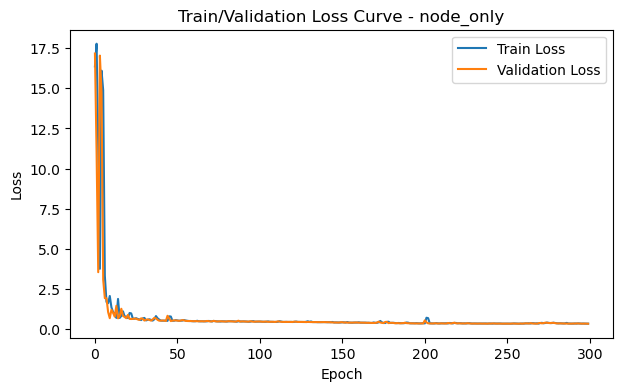

테스트 AUC: 0.9271
테스트 AUPR: 0.9314
평균 정밀도(AP): 0.9314
최적 임계값: 0.40, 최고 F1 점수: 0.8521
Precision@10: 1.0000, Recall@10: 0.0001
Precision@20: 1.0000, Recall@20: 0.0001
Precision@50: 1.0000, Recall@50: 0.0001
Precision@100: 1.0000, Recall@100: 0.0001

==== node_network 실험 시작 ====
Epoch: 0, Train Loss: 0.6936, Val Loss: 0.6795
Epoch: 30, Train Loss: 0.3976, Val Loss: 0.3913
Epoch: 60, Train Loss: 0.3292, Val Loss: 0.3273
Epoch: 90, Train Loss: 0.2875, Val Loss: 0.2863
Epoch: 120, Train Loss: 0.2766, Val Loss: 0.2761
Epoch: 150, Train Loss: 0.2681, Val Loss: 0.2735
Epoch: 180, Train Loss: 0.2595, Val Loss: 0.2669
Epoch: 210, Train Loss: 0.2518, Val Loss: 0.2602
Epoch: 240, Train Loss: 0.2436, Val Loss: 0.2519
Epoch: 270, Train Loss: 0.2335, Val Loss: 0.2446
Epoch: 299, Train Loss: 0.2240, Val Loss: 0.2332


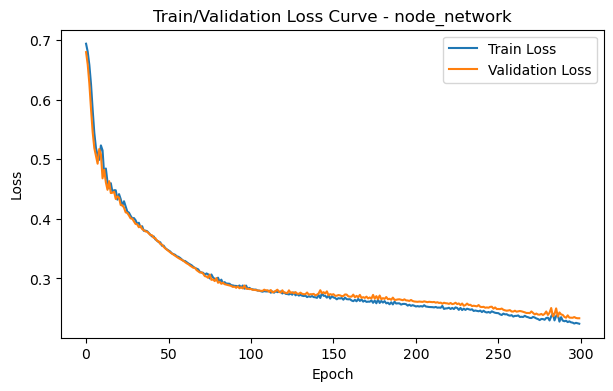

테스트 AUC: 0.9674
테스트 AUPR: 0.9637
평균 정밀도(AP): 0.9637
최적 임계값: 0.40, 최고 F1 점수: 0.9092
Precision@10: 1.0000, Recall@10: 0.0001
Precision@20: 1.0000, Recall@20: 0.0001
Precision@50: 1.0000, Recall@50: 0.0001
Precision@100: 1.0000, Recall@100: 0.0001

==== centrality 실험 시작 ====
Epoch: 0, Train Loss: 0.6936, Val Loss: 0.6789
Epoch: 30, Train Loss: 0.4378, Val Loss: 0.4444
Epoch: 60, Train Loss: 0.4074, Val Loss: 0.4098
Epoch: 90, Train Loss: 0.3930, Val Loss: 0.3916
Epoch: 120, Train Loss: 0.3637, Val Loss: 0.3730
Epoch: 150, Train Loss: 0.3548, Val Loss: 0.3531
Epoch: 180, Train Loss: 0.3522, Val Loss: 0.3493
Epoch: 210, Train Loss: 0.3444, Val Loss: 0.3489
Epoch: 240, Train Loss: 0.3413, Val Loss: 0.3435
Epoch: 270, Train Loss: 0.3396, Val Loss: 0.3392
Epoch: 299, Train Loss: 0.3391, Val Loss: 0.3365


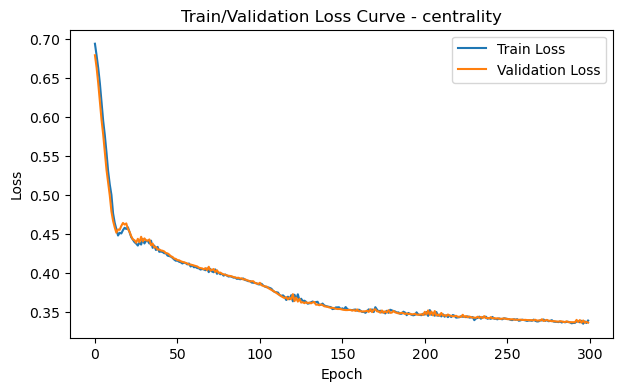

테스트 AUC: 0.9323
테스트 AUPR: 0.9354
평균 정밀도(AP): 0.9354
최적 임계값: 0.40, 최고 F1 점수: 0.8537
Precision@10: 1.0000, Recall@10: 0.0001
Precision@20: 1.0000, Recall@20: 0.0001
Precision@50: 1.0000, Recall@50: 0.0001
Precision@100: 1.0000, Recall@100: 0.0001

==== n2v 실험 시작 ====
Epoch: 0, Train Loss: 0.6932, Val Loss: 0.6742
Epoch: 30, Train Loss: 0.3817, Val Loss: 0.3865
Epoch: 60, Train Loss: 0.3269, Val Loss: 0.3284
Epoch: 90, Train Loss: 0.2882, Val Loss: 0.2872
Epoch: 120, Train Loss: 0.2751, Val Loss: 0.2806
Epoch: 150, Train Loss: 0.2680, Val Loss: 0.2733
Epoch: 180, Train Loss: 0.2590, Val Loss: 0.2675
Epoch: 210, Train Loss: 0.2514, Val Loss: 0.2579
Epoch: 240, Train Loss: 0.2391, Val Loss: 0.2466
Epoch: 270, Train Loss: 0.2294, Val Loss: 0.2412
Epoch: 299, Train Loss: 0.2196, Val Loss: 0.2287


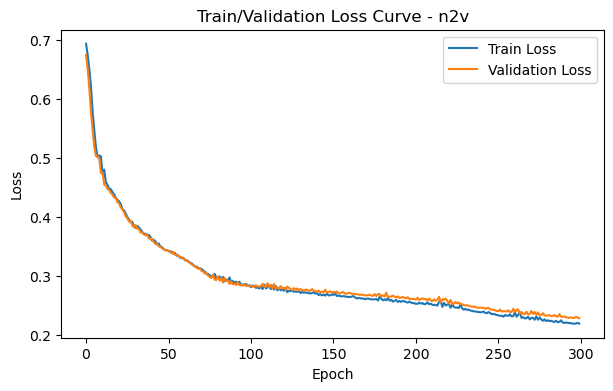

테스트 AUC: 0.9686
테스트 AUPR: 0.9650
평균 정밀도(AP): 0.9650
최적 임계값: 0.40, 최고 F1 점수: 0.9111
Precision@10: 1.0000, Recall@10: 0.0001
Precision@20: 1.0000, Recall@20: 0.0001
Precision@50: 1.0000, Recall@50: 0.0001
Precision@100: 1.0000, Recall@100: 0.0001

==== d2v 실험 시작 ====
특징 행렬에 NaN 값이 있습니다. 0으로 대체합니다.
Epoch: 0, Train Loss: 0.6936, Val Loss: 0.6633
Epoch: 30, Train Loss: 0.4824, Val Loss: 0.4877
Epoch: 60, Train Loss: 0.4706, Val Loss: 0.4740
Epoch: 90, Train Loss: 0.4662, Val Loss: 0.4648
Epoch: 120, Train Loss: 0.4444, Val Loss: 0.4430
Epoch: 150, Train Loss: 0.4438, Val Loss: 0.4381
Epoch: 180, Train Loss: 0.4230, Val Loss: 0.4191
Epoch: 210, Train Loss: 0.4517, Val Loss: 0.4510
Epoch: 240, Train Loss: 0.3866, Val Loss: 0.3891
Epoch: 270, Train Loss: 0.3774, Val Loss: 0.3850
Epoch: 299, Train Loss: 0.3665, Val Loss: 0.3727


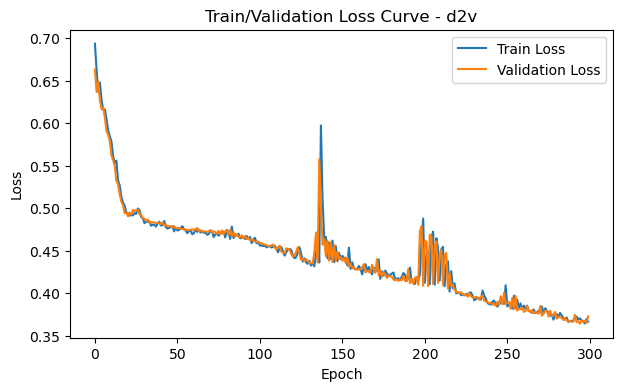

테스트 AUC: 0.9185
테스트 AUPR: 0.9189
평균 정밀도(AP): 0.9190
최적 임계값: 0.50, 최고 F1 점수: 0.8378
Precision@10: 1.0000, Recall@10: 0.0001
Precision@20: 1.0000, Recall@20: 0.0001
Precision@50: 1.0000, Recall@50: 0.0001
Precision@100: 1.0000, Recall@100: 0.0001

==== bert 실험 시작 ====
특징 행렬에 NaN 값이 있습니다. 0으로 대체합니다.
Epoch: 0, Train Loss: 0.6905, Val Loss: 0.6810
Epoch: 30, Train Loss: 0.4487, Val Loss: 0.4773
Epoch: 60, Train Loss: 0.4020, Val Loss: 0.4016
Epoch: 90, Train Loss: 0.3532, Val Loss: 0.3520
Epoch: 120, Train Loss: 0.3414, Val Loss: 0.3367
Epoch: 150, Train Loss: 0.3282, Val Loss: 0.3241
Epoch: 180, Train Loss: 0.3125, Val Loss: 0.3128
Epoch: 210, Train Loss: 0.3058, Val Loss: 0.3064
Epoch: 240, Train Loss: 0.2843, Val Loss: 0.2821
Epoch: 270, Train Loss: 0.2733, Val Loss: 0.2762
Epoch: 299, Train Loss: 0.2682, Val Loss: 0.2740


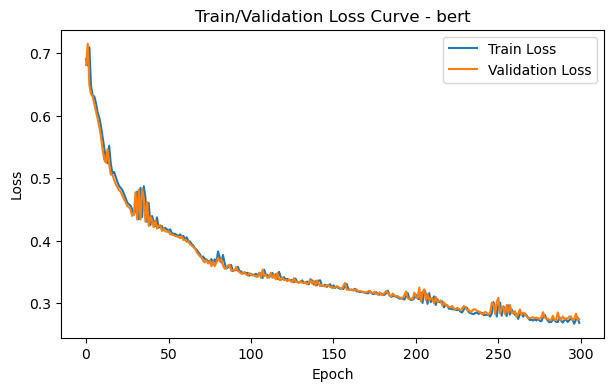

테스트 AUC: 0.9552
테스트 AUPR: 0.9530
평균 정밀도(AP): 0.9530
최적 임계값: 0.40, 최고 F1 점수: 0.8882
Precision@10: 1.0000, Recall@10: 0.0001
Precision@20: 1.0000, Recall@20: 0.0001
Precision@50: 1.0000, Recall@50: 0.0001
Precision@100: 1.0000, Recall@100: 0.0001

==== all_d2v 실험 시작 ====
특징 행렬에 NaN 값이 있습니다. 0으로 대체합니다.
Epoch: 0, Train Loss: 1.4804, Val Loss: 9.2150
Epoch: 30, Train Loss: 0.6970, Val Loss: 0.5820
Epoch: 60, Train Loss: 0.4503, Val Loss: 0.4446
Epoch: 90, Train Loss: 0.4089, Val Loss: 0.4153


KeyboardInterrupt: 

In [37]:
results = {}

for name, feature_matrix in feature_matrices.items():
    print(f"\n==== {name} 실험 시작 ====")
    
    # NaN 처리
    if np.isnan(feature_matrix).any():
        print("특징 행렬에 NaN 값이 있습니다. 0으로 대체합니다.")
        feature_matrix = np.nan_to_num(feature_matrix, nan=0.0)

    # ipc_to_idx 재생성 (feature matrix에 맞는 노드 리스트 기준)
    node_list = list(df['ipc'])  # feature matrix의 행 순서와 반드시 일치!
    ipc_to_idx = {ipc: idx for idx, ipc in enumerate(node_list)}

    # 링크 feature/label 생성 (각 반복마다 새로)
    all_links = positive_links + negative_links
    link_features = [(ipc_to_idx[src], ipc_to_idx[dst]) for src, dst, _ in all_links if src in ipc_to_idx and dst in ipc_to_idx]
    link_labels = [label for src, dst, label in all_links if src in ipc_to_idx and dst in ipc_to_idx]

    # train/validation만 분할 (test set은 이미 따로 존재)
    train_links, val_links, train_labels, val_labels = train_test_split(
        link_features, link_labels, test_size=0.2, random_state=42, stratify=link_labels
    )

    # PyTorch Geometric 데이터 객체 생성
    edge_index = torch.tensor(np.array([rows, cols]), dtype=torch.long)
    edge_weight = torch.tensor(values, dtype=torch.float)
    x = torch.tensor(feature_matrix, dtype=torch.float)
    data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

    # 모델 초기화
    model = GCNLinkPredictor(
        in_channels=feature_matrix.shape[1],
        hidden_channels=128,
        out_channels=64
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)
    criterion = nn.BCEWithLogitsLoss()

    train_edge_index = torch.tensor(train_links, dtype=torch.long).t()
    val_edge_index = torch.tensor(val_links, dtype=torch.long).t()
    train_targets = torch.tensor(train_labels, dtype=torch.float).view(-1, 1)
    val_targets = torch.tensor(val_labels, dtype=torch.float).view(-1, 1)

    train_losses = []
    val_losses = []

    for epoch in range(300):
        model.train()
        optimizer.zero_grad()
        pred_train = model(x, edge_index, edge_weight, train_edge_index)
        loss_train = criterion(pred_train, train_targets)
        loss_train.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss_train.item())

        # validation loss
        model.eval()
        with torch.no_grad():
            pred_val = model(x, edge_index, edge_weight, val_edge_index)
            loss_val = criterion(pred_val, val_targets)
            val_losses.append(loss_val.item())

        if epoch % 30 == 0 or epoch == 299:
            print(f'Epoch: {epoch}, Train Loss: {loss_train.item():.4f}, Val Loss: {loss_val.item():.4f}')

    # 학습/검증 손실 시각화
    plt.figure(figsize=(7, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Train/Validation Loss Curve - {name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    results[name] = {'train_loss': train_losses, 'val_loss': val_losses}
    filtered_test_positive_links = []
    filtered_test_negative_links = []
    for src, dst, label in test_positive_links:
        if src in ipc_to_idx and dst in ipc_to_idx:
            filtered_test_positive_links.append((ipc_to_idx[src], ipc_to_idx[dst], label))
    sampled_negatives = random.sample(test_negative_links, len(filtered_test_positive_links))
    for src, dst, label in sampled_negatives:
        if src in ipc_to_idx and dst in ipc_to_idx:
            filtered_test_negative_links.append((ipc_to_idx[src], ipc_to_idx[dst], label))
    filtered_test_links = filtered_test_positive_links + filtered_test_negative_links
    test_labels = [link[2] for link in filtered_test_links]
    filtered_test_edge_index = torch.tensor([(link[0], link[1]) for link in filtered_test_links], dtype=torch.long).t()

    from sklearn.metrics import precision_recall_curve, auc, f1_score, precision_score, recall_score, average_precision_score

    model.eval()
    with torch.no_grad():
        pred_scores = model(x, edge_index, edge_weight, filtered_test_edge_index)
        pred_scores = pred_scores.sigmoid().detach().numpy()
        auc_score = roc_auc_score(test_labels, pred_scores)
        precision, recall, _ = precision_recall_curve(test_labels, pred_scores)
        aupr = auc(recall, precision)
        ap = average_precision_score(test_labels, pred_scores)
        f1_scores = []
        thresholds = np.arange(0.1, 1.0, 0.1)
        for threshold in thresholds:
            y_pred = (pred_scores >= threshold).astype(int)
            f1 = f1_score(test_labels, y_pred)
            f1_scores.append(f1)
        best_threshold = thresholds[np.argmax(f1_scores)]
        best_f1 = max(f1_scores)
        k_values = [10, 20, 50, 100]
        precision_at_k = {}
        recall_at_k = {}
        for k in k_values:
            top_k_indices = np.argsort(pred_scores)[-k:]
            top_k_predictions = np.zeros_like(pred_scores)
            top_k_predictions[top_k_indices] = 1
            precision_at_k[k] = precision_score(test_labels, top_k_predictions)
            recall_at_k[k] = recall_score(test_labels, top_k_predictions)

        # 결과 저장
        results[name] = {
            'train_loss': train_losses,
            'val_loss': val_losses,
            'test_auc': auc_score,
            'test_aupr': aupr,
            'test_ap': ap,
            'test_best_f1': best_f1,
            'test_best_threshold': best_threshold,
            'test_precision_at_k': precision_at_k,
            'test_recall_at_k': recall_at_k
        }

        print(f"테스트 AUC: {auc_score:.4f}")
        print(f"테스트 AUPR: {aupr:.4f}")
        print(f"평균 정밀도(AP): {ap:.4f}")
        print(f"최적 임계값: {best_threshold:.2f}, 최고 F1 점수: {best_f1:.4f}")
        for k in k_values:
            print(f"Precision@{k}: {precision_at_k[k]:.4f}, Recall@{k}: {recall_at_k[k]:.4f}")


### 2024 test link prediction

In [223]:
adj_2024=pd.read_csv('adj_test.csv', encoding='utf-8-sig')

In [224]:
# 테스트 IPC 코드와 학습 IPC 코드 간 매핑 확인
train_ipcs = set(df['ipc'])
test_ipcs = set(adj_2024.iloc[:, 0])

# 공통 IPC 코드만 필터링
common_ipcs = train_ipcs.intersection(test_ipcs)
print(f"학습 IPC 코드: {len(train_ipcs)}, 테스트 IPC 코드: {len(test_ipcs)}, 공통 IPC 코드: {len(common_ipcs)}")

학습 IPC 코드: 1441, 테스트 IPC 코드: 961, 공통 IPC 코드: 792


In [35]:
# 공통 IPC 코드만 사용하여 테스트 링크 필터링
filtered_test_positive_links = []
filtered_test_negative_links = []

# ipc_to_idx 딕셔너리가 학습 과정에서 사용한 IPC 코드 → 인덱스 매핑이라고 가정
for src, dst, label in test_positive_links:
    if src in ipc_to_idx and dst in ipc_to_idx:
        filtered_test_positive_links.append((ipc_to_idx[src], ipc_to_idx[dst], label))

# 부정적 링크도 동일하게 필터링 (샘플 크기 제한)
sampled_negatives = random.sample(test_negative_links, len(filtered_test_positive_links))
for src, dst, label in sampled_negatives:
    if src in ipc_to_idx and dst in ipc_to_idx:
        filtered_test_negative_links.append((ipc_to_idx[src], ipc_to_idx[dst], label))

# 필터링된 테스트 링크 결합
filtered_test_links = filtered_test_positive_links + filtered_test_negative_links
test_labels = [link[2] for link in filtered_test_links]
filtered_test_edge_index = torch.tensor([(link[0], link[1]) for link in filtered_test_links], dtype=torch.long).t()

NameError: name 'test_positive_links' is not defined

In [226]:
from sklearn.metrics import precision_recall_curve, auc, f1_score, precision_score, recall_score, average_precision_score

# 기존 코드
model.eval()
with torch.no_grad():
    pred_scores = model(x, edge_index, edge_weight, filtered_test_edge_index)
    pred_scores = pred_scores.sigmoid().detach().numpy()
    
    # 1. AUC-ROC 계산
    auc_score = roc_auc_score(test_labels, pred_scores)
    
    # 2. AUPR (Area Under Precision-Recall Curve) 계산
    precision, recall, _ = precision_recall_curve(test_labels, pred_scores)
    aupr = auc(recall, precision)
    
    # 3. 평균 정밀도(Average Precision) 계산
    ap = average_precision_score(test_labels, pred_scores)
    
    # 4. 최적 임계값에서의 F1 점수 계산
    # 여러 임계값을 시도하여 최적의 F1 점수 찾기
    f1_scores = []
    thresholds = np.arange(0.1, 1.0, 0.1)
    
    for threshold in thresholds:
        y_pred = (pred_scores >= threshold).astype(int)
        f1 = f1_score(test_labels, y_pred)
        f1_scores.append(f1)
    
    best_threshold = thresholds[np.argmax(f1_scores)]
    best_f1 = max(f1_scores)
    
    # 5. Precision@k 및 Recall@k 계산
    k_values = [10, 20, 50, 100]
    precision_at_k = {}
    recall_at_k = {}
    
    # 각 노드별 상위 k개 예측 성능 계산
    for k in k_values:
        # 상위 k개 예측이 실제 링크인지 확인
        top_k_indices = np.argsort(pred_scores)[-k:]
        top_k_predictions = np.zeros_like(pred_scores)
        top_k_predictions[top_k_indices] = 1
        
        precision_at_k[k] = precision_score(test_labels, top_k_predictions)
        recall_at_k[k] = recall_score(test_labels, top_k_predictions)
    
    # 결과 출력
    print(f"테스트 AUC: {auc_score:.4f}")
    print(f"테스트 AUPR: {aupr:.4f}")
    print(f"평균 정밀도(AP): {ap:.4f}")
    print(f"최적 임계값: {best_threshold:.2f}, 최고 F1 점수: {best_f1:.4f}")
    
    for k in k_values:
        print(f"Precision@{k}: {precision_at_k[k]:.4f}, Recall@{k}: {recall_at_k[k]:.4f}")


테스트 AUC: 0.9209
테스트 AUPR: 0.9454
평균 정밀도(AP): 0.9454
최적 임계값: 0.60, 최고 F1 점수: 0.8767
Precision@10: 1.0000, Recall@10: 0.0001
Precision@20: 1.0000, Recall@20: 0.0001
Precision@50: 1.0000, Recall@50: 0.0001
Precision@100: 1.0000, Recall@100: 0.0001


### 파생모형들

#### GAT

In [33]:
from torch_geometric.nn import GATConv

class GATLinkPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)
        self.predictor = nn.Sequential(
            nn.Linear(out_channels * 2, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1)
        )
    
    def encode(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    
    def decode(self, z, edge_index):
        src, dst = edge_index
        x = torch.cat([z[src], z[dst]], dim=1)
        return self.predictor(x)
    
    def forward(self, x, edge_index, edge_weight, pred_edge_index):
        z = self.encode(x, edge_index)
        return self.decode(z, pred_edge_index)



==== node_only 실험 시작 ====
Epoch: 0, Train Loss: 1.1810, Val Loss: 3.4129
Epoch: 30, Train Loss: 0.4648, Val Loss: 0.4611
Epoch: 60, Train Loss: 0.4291, Val Loss: 0.4270
Epoch: 90, Train Loss: 0.4229, Val Loss: 0.4116
Epoch: 120, Train Loss: 0.4018, Val Loss: 0.4006
Epoch: 150, Train Loss: 0.3965, Val Loss: 0.3933
Epoch: 180, Train Loss: 0.3957, Val Loss: 0.3916
Epoch: 210, Train Loss: 0.3843, Val Loss: 0.3755
Epoch: 240, Train Loss: 0.3874, Val Loss: 0.3823
Epoch: 270, Train Loss: 0.3590, Val Loss: 0.3717
Epoch: 299, Train Loss: 0.3557, Val Loss: 0.3523


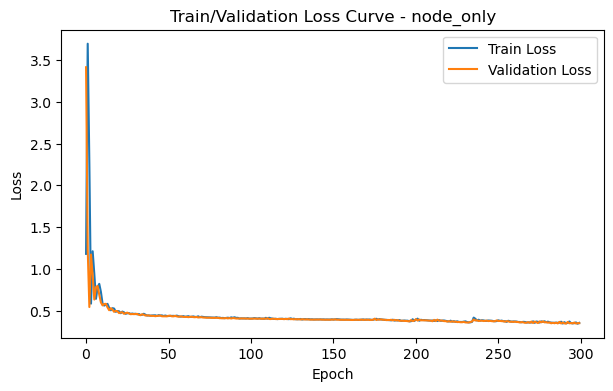

NameError: name 'test_positive_links' is not defined

In [34]:
results = {}

for name, feature_matrix in feature_matrices.items():
    print(f"\n==== {name} 실험 시작 ====")
    
    # NaN 처리
    if np.isnan(feature_matrix).any():
        print("특징 행렬에 NaN 값이 있습니다. 0으로 대체합니다.")
        feature_matrix = np.nan_to_num(feature_matrix, nan=0.0)

    # ipc_to_idx 재생성 (feature matrix에 맞는 노드 리스트 기준)
    node_list = list(df['ipc'])  # feature matrix의 행 순서와 반드시 일치!
    ipc_to_idx = {ipc: idx for idx, ipc in enumerate(node_list)}

    # 링크 feature/label 생성 (각 반복마다 새로)
    all_links = positive_links + negative_links
    link_features = [(ipc_to_idx[src], ipc_to_idx[dst]) for src, dst, _ in all_links if src in ipc_to_idx and dst in ipc_to_idx]
    link_labels = [label for src, dst, label in all_links if src in ipc_to_idx and dst in ipc_to_idx]

    # train/validation만 분할 (test set은 이미 따로 존재)
    train_links, val_links, train_labels, val_labels = train_test_split(
        link_features, link_labels, test_size=0.2, random_state=42, stratify=link_labels
    )

    # PyTorch Geometric 데이터 객체 생성
    edge_index = torch.tensor(np.array([rows, cols]), dtype=torch.long)
    edge_weight = torch.tensor(values, dtype=torch.float)
    x = torch.tensor(feature_matrix, dtype=torch.float)
    data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

    model = GATLinkPredictor(
        in_channels=feature_matrix.shape[1],
        hidden_channels=128,
        out_channels=64,
        heads=2   # heads는 필요에 따라 조정
)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)
    criterion = nn.BCEWithLogitsLoss()

    train_edge_index = torch.tensor(train_links, dtype=torch.long).t()
    val_edge_index = torch.tensor(val_links, dtype=torch.long).t()
    train_targets = torch.tensor(train_labels, dtype=torch.float).view(-1, 1)
    val_targets = torch.tensor(val_labels, dtype=torch.float).view(-1, 1)

    train_losses = []
    val_losses = []

    for epoch in range(300):
        model.train()
        optimizer.zero_grad()
        pred_train = model(x, edge_index, edge_weight, train_edge_index)
        loss_train = criterion(pred_train, train_targets)
        loss_train.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss_train.item())

        # validation loss
        model.eval()
        with torch.no_grad():
            pred_val = model(x, edge_index, edge_weight, val_edge_index)
            loss_val = criterion(pred_val, val_targets)
            val_losses.append(loss_val.item())

        if epoch % 30 == 0 or epoch == 299:
            print(f'Epoch: {epoch}, Train Loss: {loss_train.item():.4f}, Val Loss: {loss_val.item():.4f}')

    # 학습/검증 손실 시각화
    plt.figure(figsize=(7, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Train/Validation Loss Curve - {name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    results[name] = {'train_loss': train_losses, 'val_loss': val_losses}
    filtered_test_positive_links = []
    filtered_test_negative_links = []
    for src, dst, label in test_positive_links:
        if src in ipc_to_idx and dst in ipc_to_idx:
            filtered_test_positive_links.append((ipc_to_idx[src], ipc_to_idx[dst], label))
    sampled_negatives = random.sample(test_negative_links, len(filtered_test_positive_links))
    for src, dst, label in sampled_negatives:
        if src in ipc_to_idx and dst in ipc_to_idx:
            filtered_test_negative_links.append((ipc_to_idx[src], ipc_to_idx[dst], label))
    filtered_test_links = filtered_test_positive_links + filtered_test_negative_links
    test_labels = [link[2] for link in filtered_test_links]
    filtered_test_edge_index = torch.tensor([(link[0], link[1]) for link in filtered_test_links], dtype=torch.long).t()

    from sklearn.metrics import precision_recall_curve, auc, f1_score, precision_score, recall_score, average_precision_score

    model.eval()
    with torch.no_grad():
        pred_scores = model(x, edge_index, edge_weight, filtered_test_edge_index)
        pred_scores = pred_scores.sigmoid().detach().numpy()
        auc_score = roc_auc_score(test_labels, pred_scores)
        precision, recall, _ = precision_recall_curve(test_labels, pred_scores)
        aupr = auc(recall, precision)
        ap = average_precision_score(test_labels, pred_scores)
        f1_scores = []
        thresholds = np.arange(0.1, 1.0, 0.1)
        for threshold in thresholds:
            y_pred = (pred_scores >= threshold).astype(int)
            f1 = f1_score(test_labels, y_pred)
            f1_scores.append(f1)
        best_threshold = thresholds[np.argmax(f1_scores)]
        best_f1 = max(f1_scores)
        k_values = [10, 20, 50, 100]
        precision_at_k = {}
        recall_at_k = {}
        for k in k_values:
            top_k_indices = np.argsort(pred_scores)[-k:]
            top_k_predictions = np.zeros_like(pred_scores)
            top_k_predictions[top_k_indices] = 1
            precision_at_k[k] = precision_score(test_labels, top_k_predictions)
            recall_at_k[k] = recall_score(test_labels, top_k_predictions)

        # 결과 저장
        results[name] = {
            'train_loss': train_losses,
            'val_loss': val_losses,
            'test_auc': auc_score,
            'test_aupr': aupr,
            'test_ap': ap,
            'test_best_f1': best_f1,
            'test_best_threshold': best_threshold,
            'test_precision_at_k': precision_at_k,
            'test_recall_at_k': recall_at_k
        }

        print(f"테스트 AUC: {auc_score:.4f}")
        print(f"테스트 AUPR: {aupr:.4f}")
        print(f"평균 정밀도(AP): {ap:.4f}")
        print(f"최적 임계값: {best_threshold:.2f}, 최고 F1 점수: {best_f1:.4f}")
        for k in k_values:
            print(f"Precision@{k}: {precision_at_k[k]:.4f}, Recall@{k}: {recall_at_k[k]:.4f}")


#### GrapeSAGE

In [233]:
from torch_geometric.nn import SAGEConv

class SAGELinkPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.predictor = nn.Sequential(
            nn.Linear(out_channels * 2, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1)
        )
    def encode(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    def decode(self, z, edge_index):
        src, dst = edge_index
        x = torch.cat([z[src], z[dst]], dim=1)
        return self.predictor(x)
    def forward(self, x, edge_index, edge_weight, pred_edge_index):
        z = self.encode(x, edge_index)
        return self.decode(z, pred_edge_index)



==== node_only 실험 시작 ====
Epoch: 0, Train Loss: 28.5722, Val Loss: 220.6018
Epoch: 30, Train Loss: 0.7725, Val Loss: 0.6027
Epoch: 60, Train Loss: 0.4435, Val Loss: 0.4319
Epoch: 90, Train Loss: 0.4194, Val Loss: 0.3921
Epoch: 120, Train Loss: 0.3815, Val Loss: 0.3868
Epoch: 150, Train Loss: 0.4026, Val Loss: 0.4060
Epoch: 180, Train Loss: 0.4026, Val Loss: 0.3776
Epoch: 210, Train Loss: 0.3775, Val Loss: 0.4344
Epoch: 240, Train Loss: 0.4754, Val Loss: 0.4538
Epoch: 270, Train Loss: 0.4194, Val Loss: 0.4232
Epoch: 299, Train Loss: 0.3561, Val Loss: 0.3871


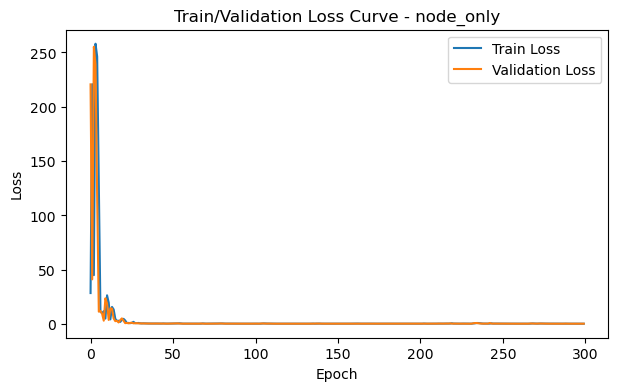

테스트 AUC: 0.8802
테스트 AUPR: 0.9208
평균 정밀도(AP): 0.9208
최적 임계값: 0.30, 최고 F1 점수: 0.8377
Precision@10: 1.0000, Recall@10: 0.0001
Precision@20: 1.0000, Recall@20: 0.0001
Precision@50: 1.0000, Recall@50: 0.0001
Precision@100: 1.0000, Recall@100: 0.0001

==== node_network 실험 시작 ====
Epoch: 0, Train Loss: 0.6924, Val Loss: 0.6836
Epoch: 30, Train Loss: 0.3363, Val Loss: 0.3252
Epoch: 60, Train Loss: 0.2767, Val Loss: 0.2689
Epoch: 90, Train Loss: 0.2357, Val Loss: 0.2351
Epoch: 120, Train Loss: 0.2045, Val Loss: 0.2059
Epoch: 150, Train Loss: 0.1736, Val Loss: 0.1850
Epoch: 180, Train Loss: 0.1605, Val Loss: 0.1714
Epoch: 210, Train Loss: 0.1507, Val Loss: 0.1627
Epoch: 240, Train Loss: 0.1342, Val Loss: 0.1546
Epoch: 270, Train Loss: 0.1265, Val Loss: 0.1524
Epoch: 299, Train Loss: 0.1223, Val Loss: 0.1516


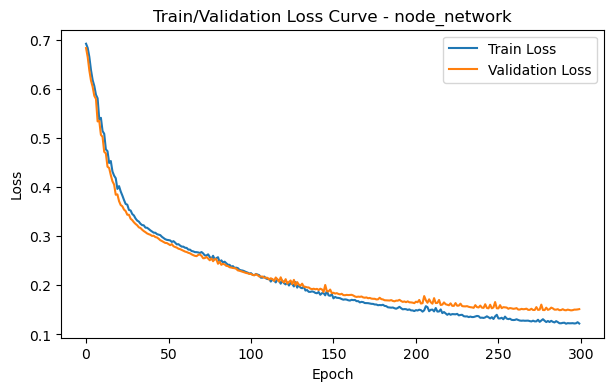

테스트 AUC: 0.9396
테스트 AUPR: 0.9578
평균 정밀도(AP): 0.9578
최적 임계값: 0.60, 최고 F1 점수: 0.9016
Precision@10: 1.0000, Recall@10: 0.0001
Precision@20: 1.0000, Recall@20: 0.0001
Precision@50: 1.0000, Recall@50: 0.0001
Precision@100: 1.0000, Recall@100: 0.0001

==== n2v 실험 시작 ====
Epoch: 0, Train Loss: 0.6933, Val Loss: 0.6852
Epoch: 30, Train Loss: 0.3457, Val Loss: 0.3310
Epoch: 60, Train Loss: 0.2482, Val Loss: 0.2434
Epoch: 90, Train Loss: 0.2110, Val Loss: 0.2102
Epoch: 120, Train Loss: 0.1852, Val Loss: 0.1927
Epoch: 150, Train Loss: 0.1728, Val Loss: 0.1825
Epoch: 180, Train Loss: 0.1578, Val Loss: 0.1779
Epoch: 210, Train Loss: 0.1492, Val Loss: 0.1732
Epoch: 240, Train Loss: 0.1420, Val Loss: 0.1671
Epoch: 270, Train Loss: 0.1375, Val Loss: 0.1647
Epoch: 299, Train Loss: 0.1364, Val Loss: 0.1601


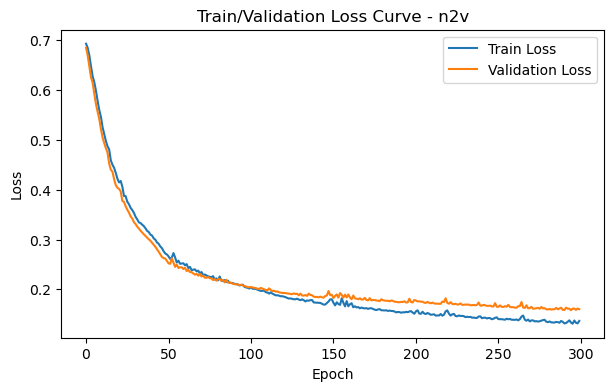

테스트 AUC: 0.9377
테스트 AUPR: 0.9552
평균 정밀도(AP): 0.9552
최적 임계값: 0.60, 최고 F1 점수: 0.9011
Precision@10: 1.0000, Recall@10: 0.0001
Precision@20: 1.0000, Recall@20: 0.0001
Precision@50: 1.0000, Recall@50: 0.0001
Precision@100: 1.0000, Recall@100: 0.0001

==== d2v 실험 시작 ====
특징 행렬에 NaN 값이 있습니다. 0으로 대체합니다.
Epoch: 0, Train Loss: 0.6935, Val Loss: 0.6935
Epoch: 30, Train Loss: 0.6549, Val Loss: 0.6469
Epoch: 60, Train Loss: 0.6456, Val Loss: 0.6288
Epoch: 90, Train Loss: 0.6178, Val Loss: 0.5936
Epoch: 120, Train Loss: 0.6132, Val Loss: 0.6052
Epoch: 150, Train Loss: 0.5872, Val Loss: 0.5648
Epoch: 180, Train Loss: 0.6030, Val Loss: 0.5780
Epoch: 210, Train Loss: 0.5273, Val Loss: 0.5265
Epoch: 240, Train Loss: 0.5082, Val Loss: 0.4682
Epoch: 270, Train Loss: 0.5001, Val Loss: 0.4665
Epoch: 299, Train Loss: 0.4958, Val Loss: 0.4638


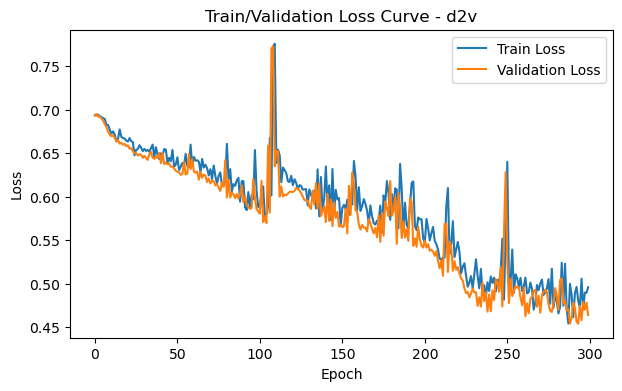

테스트 AUC: 0.8336
테스트 AUPR: 0.8822
평균 정밀도(AP): 0.8822
최적 임계값: 0.50, 최고 F1 점수: 0.8019
Precision@10: 1.0000, Recall@10: 0.0001
Precision@20: 1.0000, Recall@20: 0.0001
Precision@50: 1.0000, Recall@50: 0.0001
Precision@100: 1.0000, Recall@100: 0.0001

==== bert 실험 시작 ====
특징 행렬에 NaN 값이 있습니다. 0으로 대체합니다.
Epoch: 0, Train Loss: 0.6949, Val Loss: 0.7725
Epoch: 30, Train Loss: 0.4960, Val Loss: 0.4734
Epoch: 60, Train Loss: 0.3970, Val Loss: 0.3849
Epoch: 90, Train Loss: 0.3348, Val Loss: 0.3274
Epoch: 120, Train Loss: 0.2945, Val Loss: 0.2857
Epoch: 150, Train Loss: 0.2640, Val Loss: 0.2544
Epoch: 180, Train Loss: 0.2525, Val Loss: 0.2458
Epoch: 210, Train Loss: 0.2566, Val Loss: 0.2397
Epoch: 240, Train Loss: 0.2511, Val Loss: 0.2350
Epoch: 270, Train Loss: 0.2348, Val Loss: 0.2306
Epoch: 299, Train Loss: 0.2341, Val Loss: 0.2288


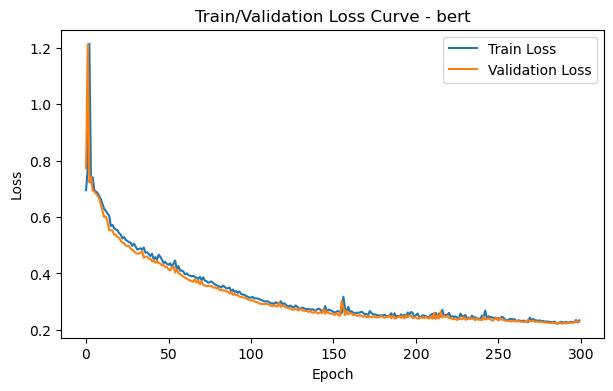

테스트 AUC: 0.9317
테스트 AUPR: 0.9520
평균 정밀도(AP): 0.9521
최적 임계값: 0.40, 최고 F1 점수: 0.8890
Precision@10: 1.0000, Recall@10: 0.0001
Precision@20: 1.0000, Recall@20: 0.0001
Precision@50: 1.0000, Recall@50: 0.0001
Precision@100: 1.0000, Recall@100: 0.0001

==== all_d2v 실험 시작 ====
특징 행렬에 NaN 값이 있습니다. 0으로 대체합니다.
Epoch: 0, Train Loss: 3.8849, Val Loss: 47.7313
Epoch: 30, Train Loss: 0.4682, Val Loss: 0.4136
Epoch: 60, Train Loss: 0.3759, Val Loss: 0.3626
Epoch: 90, Train Loss: 0.3347, Val Loss: 0.3334
Epoch: 120, Train Loss: 0.3391, Val Loss: 0.3386
Epoch: 150, Train Loss: 0.3106, Val Loss: 0.3040
Epoch: 180, Train Loss: 0.3004, Val Loss: 0.2855
Epoch: 210, Train Loss: 0.2809, Val Loss: 0.2804
Epoch: 240, Train Loss: 0.2756, Val Loss: 0.2607
Epoch: 270, Train Loss: 0.2820, Val Loss: 0.2705
Epoch: 299, Train Loss: 0.2917, Val Loss: 0.2786


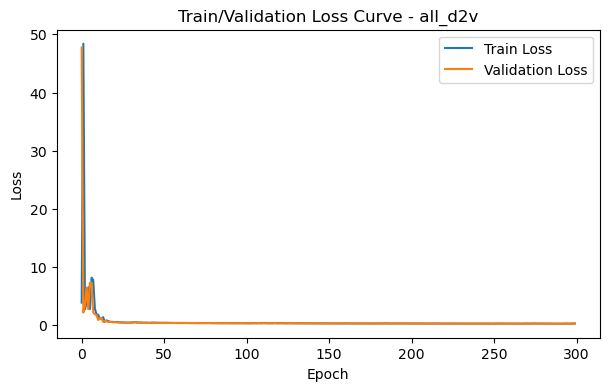

테스트 AUC: 0.9031
테스트 AUPR: 0.9355
평균 정밀도(AP): 0.9355
최적 임계값: 0.60, 최고 F1 점수: 0.8621
Precision@10: 1.0000, Recall@10: 0.0001
Precision@20: 1.0000, Recall@20: 0.0001
Precision@50: 1.0000, Recall@50: 0.0001
Precision@100: 1.0000, Recall@100: 0.0001

==== all_bert 실험 시작 ====
특징 행렬에 NaN 값이 있습니다. 0으로 대체합니다.
Epoch: 0, Train Loss: 3.0470, Val Loss: 24.9211
Epoch: 30, Train Loss: 0.4359, Val Loss: 0.3997
Epoch: 60, Train Loss: 0.3463, Val Loss: 0.3433
Epoch: 90, Train Loss: 0.3167, Val Loss: 0.3138
Epoch: 120, Train Loss: 0.2968, Val Loss: 0.2972
Epoch: 150, Train Loss: 0.2754, Val Loss: 0.2928
Epoch: 180, Train Loss: 0.2627, Val Loss: 0.2671
Epoch: 210, Train Loss: 0.2517, Val Loss: 0.2508
Epoch: 240, Train Loss: 0.2614, Val Loss: 0.2591
Epoch: 270, Train Loss: 0.2455, Val Loss: 0.2501
Epoch: 299, Train Loss: 0.2295, Val Loss: 0.2246


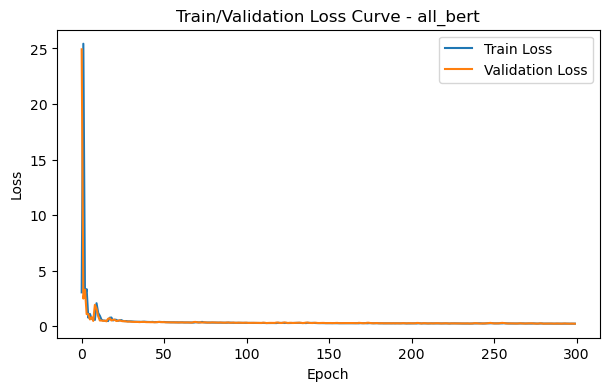

테스트 AUC: 0.9231
테스트 AUPR: 0.9468
평균 정밀도(AP): 0.9468
최적 임계값: 0.60, 최고 F1 점수: 0.8812
Precision@10: 1.0000, Recall@10: 0.0001
Precision@20: 1.0000, Recall@20: 0.0001
Precision@50: 1.0000, Recall@50: 0.0001
Precision@100: 1.0000, Recall@100: 0.0001

==== n2v_d2v 실험 시작 ====
특징 행렬에 NaN 값이 있습니다. 0으로 대체합니다.
Epoch: 0, Train Loss: 0.6938, Val Loss: 0.6872
Epoch: 30, Train Loss: 0.3889, Val Loss: 0.3602
Epoch: 60, Train Loss: 0.3006, Val Loss: 0.2944
Epoch: 90, Train Loss: 0.2766, Val Loss: 0.2706
Epoch: 120, Train Loss: 0.2415, Val Loss: 0.2385
Epoch: 150, Train Loss: 0.2226, Val Loss: 0.2190
Epoch: 180, Train Loss: 0.2052, Val Loss: 0.2077
Epoch: 210, Train Loss: 0.1896, Val Loss: 0.1997
Epoch: 240, Train Loss: 0.1809, Val Loss: 0.1908
Epoch: 270, Train Loss: 0.1713, Val Loss: 0.1919
Epoch: 299, Train Loss: 0.1634, Val Loss: 0.1746


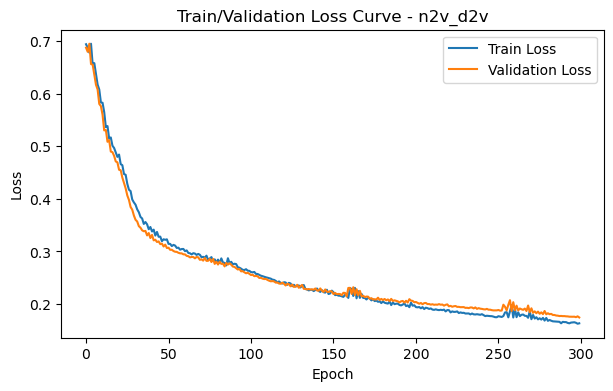

테스트 AUC: 0.9346
테스트 AUPR: 0.9530
평균 정밀도(AP): 0.9530
최적 임계값: 0.50, 최고 F1 점수: 0.8966
Precision@10: 1.0000, Recall@10: 0.0001
Precision@20: 1.0000, Recall@20: 0.0001
Precision@50: 1.0000, Recall@50: 0.0001
Precision@100: 1.0000, Recall@100: 0.0001

==== n2v_bert 실험 시작 ====
특징 행렬에 NaN 값이 있습니다. 0으로 대체합니다.
Epoch: 0, Train Loss: 0.6922, Val Loss: 0.6600
Epoch: 30, Train Loss: 0.4542, Val Loss: 0.4548
Epoch: 60, Train Loss: 0.3603, Val Loss: 0.3752
Epoch: 90, Train Loss: 0.3106, Val Loss: 0.3090
Epoch: 120, Train Loss: 0.3031, Val Loss: 0.2932
Epoch: 150, Train Loss: 0.2820, Val Loss: 0.2759
Epoch: 180, Train Loss: 0.2489, Val Loss: 0.2462
Epoch: 210, Train Loss: 0.2496, Val Loss: 0.2371
Epoch: 240, Train Loss: 0.2196, Val Loss: 0.2180
Epoch: 270, Train Loss: 0.2152, Val Loss: 0.2133
Epoch: 299, Train Loss: 0.2124, Val Loss: 0.2043


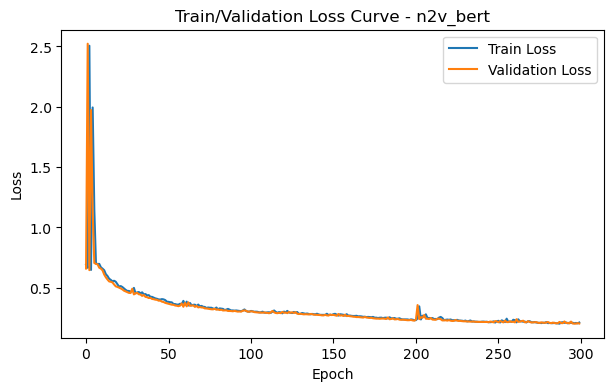

테스트 AUC: 0.9347
테스트 AUPR: 0.9536
평균 정밀도(AP): 0.9536
최적 임계값: 0.50, 최고 F1 점수: 0.8931
Precision@10: 1.0000, Recall@10: 0.0001
Precision@20: 1.0000, Recall@20: 0.0001
Precision@50: 1.0000, Recall@50: 0.0001
Precision@100: 1.0000, Recall@100: 0.0001

==== network_d2v 실험 시작 ====
특징 행렬에 NaN 값이 있습니다. 0으로 대체합니다.
Epoch: 0, Train Loss: 0.6930, Val Loss: 0.6952
Epoch: 30, Train Loss: 0.4026, Val Loss: 0.3844
Epoch: 60, Train Loss: 0.3119, Val Loss: 0.3015
Epoch: 90, Train Loss: 0.2937, Val Loss: 0.2813
Epoch: 120, Train Loss: 0.2616, Val Loss: 0.2662
Epoch: 150, Train Loss: 0.2403, Val Loss: 0.2588
Epoch: 180, Train Loss: 0.2201, Val Loss: 0.2266
Epoch: 210, Train Loss: 0.2113, Val Loss: 0.2120
Epoch: 240, Train Loss: 0.1967, Val Loss: 0.2032
Epoch: 270, Train Loss: 0.1870, Val Loss: 0.1947
Epoch: 299, Train Loss: 0.1804, Val Loss: 0.1971


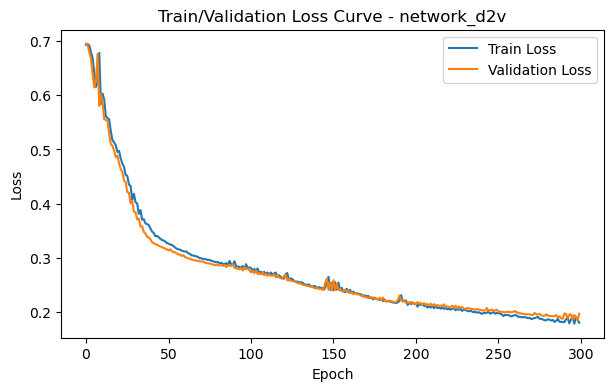

테스트 AUC: 0.9295
테스트 AUPR: 0.9497
평균 정밀도(AP): 0.9497
최적 임계값: 0.60, 최고 F1 점수: 0.8916
Precision@10: 1.0000, Recall@10: 0.0001
Precision@20: 1.0000, Recall@20: 0.0001
Precision@50: 1.0000, Recall@50: 0.0001
Precision@100: 1.0000, Recall@100: 0.0001

==== network_bert 실험 시작 ====
특징 행렬에 NaN 값이 있습니다. 0으로 대체합니다.
Epoch: 0, Train Loss: 0.6929, Val Loss: 0.8019
Epoch: 30, Train Loss: 0.4870, Val Loss: 0.4751
Epoch: 60, Train Loss: 0.3403, Val Loss: 0.3318
Epoch: 90, Train Loss: 0.3030, Val Loss: 0.2962
Epoch: 120, Train Loss: 0.2954, Val Loss: 0.2860
Epoch: 150, Train Loss: 0.2556, Val Loss: 0.2514
Epoch: 180, Train Loss: 0.2409, Val Loss: 0.2289
Epoch: 210, Train Loss: 0.2160, Val Loss: 0.2223
Epoch: 240, Train Loss: 0.1983, Val Loss: 0.1978
Epoch: 270, Train Loss: 0.1898, Val Loss: 0.1925
Epoch: 299, Train Loss: 0.1928, Val Loss: 0.2160


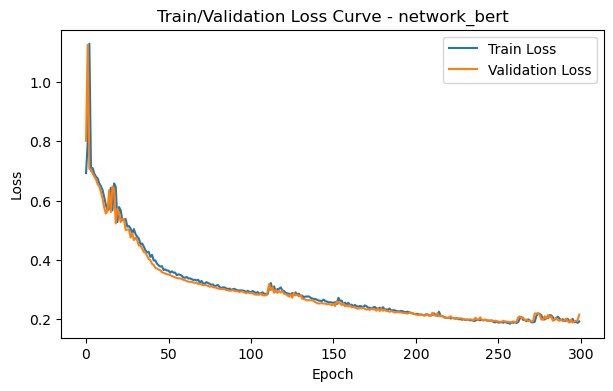

테스트 AUC: 0.9351
테스트 AUPR: 0.9540
평균 정밀도(AP): 0.9540
최적 임계값: 0.30, 최고 F1 점수: 0.8957
Precision@10: 1.0000, Recall@10: 0.0001
Precision@20: 1.0000, Recall@20: 0.0001
Precision@50: 1.0000, Recall@50: 0.0001
Precision@100: 1.0000, Recall@100: 0.0001


In [234]:
results = {}

for name, feature_matrix in feature_matrices.items():
    print(f"\n==== {name} 실험 시작 ====")
    
    # NaN 처리
    if np.isnan(feature_matrix).any():
        print("특징 행렬에 NaN 값이 있습니다. 0으로 대체합니다.")
        feature_matrix = np.nan_to_num(feature_matrix, nan=0.0)

    # ipc_to_idx 재생성 (feature matrix에 맞는 노드 리스트 기준)
    node_list = list(df['ipc'])  # feature matrix의 행 순서와 반드시 일치!
    ipc_to_idx = {ipc: idx for idx, ipc in enumerate(node_list)}

    # 링크 feature/label 생성 (각 반복마다 새로)
    all_links = positive_links + negative_links
    link_features = [(ipc_to_idx[src], ipc_to_idx[dst]) for src, dst, _ in all_links if src in ipc_to_idx and dst in ipc_to_idx]
    link_labels = [label for src, dst, label in all_links if src in ipc_to_idx and dst in ipc_to_idx]

    # train/validation만 분할 (test set은 이미 따로 존재)
    train_links, val_links, train_labels, val_labels = train_test_split(
        link_features, link_labels, test_size=0.2, random_state=42, stratify=link_labels
    )

    # PyTorch Geometric 데이터 객체 생성
    edge_index = torch.tensor(np.array([rows, cols]), dtype=torch.long)
    edge_weight = torch.tensor(values, dtype=torch.float)
    x = torch.tensor(feature_matrix, dtype=torch.float)
    data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

    model = SAGELinkPredictor(
    in_channels=feature_matrix.shape[1],
    hidden_channels=128,
    out_channels=64
)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)
    criterion = nn.BCEWithLogitsLoss()

    train_edge_index = torch.tensor(train_links, dtype=torch.long).t()
    val_edge_index = torch.tensor(val_links, dtype=torch.long).t()
    train_targets = torch.tensor(train_labels, dtype=torch.float).view(-1, 1)
    val_targets = torch.tensor(val_labels, dtype=torch.float).view(-1, 1)

    train_losses = []
    val_losses = []

    for epoch in range(300):
        model.train()
        optimizer.zero_grad()
        pred_train = model(x, edge_index, edge_weight, train_edge_index)
        loss_train = criterion(pred_train, train_targets)
        loss_train.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss_train.item())

        # validation loss
        model.eval()
        with torch.no_grad():
            pred_val = model(x, edge_index, edge_weight, val_edge_index)
            loss_val = criterion(pred_val, val_targets)
            val_losses.append(loss_val.item())

        if epoch % 30 == 0 or epoch == 299:
            print(f'Epoch: {epoch}, Train Loss: {loss_train.item():.4f}, Val Loss: {loss_val.item():.4f}')

    # 학습/검증 손실 시각화
    plt.figure(figsize=(7, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Train/Validation Loss Curve - {name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    results[name] = {'train_loss': train_losses, 'val_loss': val_losses}
    filtered_test_positive_links = []
    filtered_test_negative_links = []
    for src, dst, label in test_positive_links:
        if src in ipc_to_idx and dst in ipc_to_idx:
            filtered_test_positive_links.append((ipc_to_idx[src], ipc_to_idx[dst], label))
    sampled_negatives = random.sample(test_negative_links, len(filtered_test_positive_links))
    for src, dst, label in sampled_negatives:
        if src in ipc_to_idx and dst in ipc_to_idx:
            filtered_test_negative_links.append((ipc_to_idx[src], ipc_to_idx[dst], label))
    filtered_test_links = filtered_test_positive_links + filtered_test_negative_links
    test_labels = [link[2] for link in filtered_test_links]
    filtered_test_edge_index = torch.tensor([(link[0], link[1]) for link in filtered_test_links], dtype=torch.long).t()

    from sklearn.metrics import precision_recall_curve, auc, f1_score, precision_score, recall_score, average_precision_score

    model.eval()
    with torch.no_grad():
        pred_scores = model(x, edge_index, edge_weight, filtered_test_edge_index)
        pred_scores = pred_scores.sigmoid().detach().numpy()
        auc_score = roc_auc_score(test_labels, pred_scores)
        precision, recall, _ = precision_recall_curve(test_labels, pred_scores)
        aupr = auc(recall, precision)
        ap = average_precision_score(test_labels, pred_scores)
        f1_scores = []
        thresholds = np.arange(0.1, 1.0, 0.1)
        for threshold in thresholds:
            y_pred = (pred_scores >= threshold).astype(int)
            f1 = f1_score(test_labels, y_pred)
            f1_scores.append(f1)
        best_threshold = thresholds[np.argmax(f1_scores)]
        best_f1 = max(f1_scores)
        k_values = [10, 20, 50, 100]
        precision_at_k = {}
        recall_at_k = {}
        for k in k_values:
            top_k_indices = np.argsort(pred_scores)[-k:]
            top_k_predictions = np.zeros_like(pred_scores)
            top_k_predictions[top_k_indices] = 1
            precision_at_k[k] = precision_score(test_labels, top_k_predictions)
            recall_at_k[k] = recall_score(test_labels, top_k_predictions)

        # 결과 저장
        results[name] = {
            'train_loss': train_losses,
            'val_loss': val_losses,
            'test_auc': auc_score,
            'test_aupr': aupr,
            'test_ap': ap,
            'test_best_f1': best_f1,
            'test_best_threshold': best_threshold,
            'test_precision_at_k': precision_at_k,
            'test_recall_at_k': recall_at_k
        }

        print(f"테스트 AUC: {auc_score:.4f}")
        print(f"테스트 AUPR: {aupr:.4f}")
        print(f"평균 정밀도(AP): {ap:.4f}")
        print(f"최적 임계값: {best_threshold:.2f}, 최고 F1 점수: {best_f1:.4f}")
        for k in k_values:
            print(f"Precision@{k}: {precision_at_k[k]:.4f}, Recall@{k}: {recall_at_k[k]:.4f}")
